In [ ]:
%pip install nba_api seaborn

import pandas as pd
import time
from nba_api.stats.endpoints import leaguegamefinder, boxscoretraditionalv3, teamgamelog
from nba_api.stats.static import teams
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

In [2]:
# collects Pacer specific data
nba_teams = teams.get_teams()
pacers = [team for team in nba_teams if team['abbreviation'] == 'IND'][0]
pacers_id = pacers['id']

# Game logs data from the 2024-2025 season
gamefinder = leaguegamefinder.LeagueGameFinder(team_id_nullable=pacers_id, season_nullable='2024-25')
games_df = gamefinder.get_data_frames()[0]


games_df = games_df[['GAME_ID', 'GAME_DATE', 'MATCHUP', 'WL', 'PTS', 'PLUS_MINUS']]

# Convert WL (Win/Loss) to Binary Target: 1 for Win, 0 for Loss
games_df['Target'] = games_df['WL'].apply(lambda x: 1 if x == 'W' else 0)

# Identify Home vs Away
games_df['Home_Game'] = games_df['MATCHUP'].apply(lambda x: 1 if 'vs.' in x else 0)

print(f"Total Games Fetched: {len(games_df)}")
games_df.head()

Total Games Fetched: 109


,GAME_ID,GAME_DATE,MATCHUP,WL,PTS,PLUS_MINUS,Target,Home_Game
0,0042400407,2025-06-22,IND @ OKC,L,91,-12.0,0,0
1,0042400406,2025-06-19,IND vs. OKC,W,108,17.0,1,1
2,0042400405,2025-06-16,IND @ OKC,L,109,-11.0,0,0
3,0042400404,2025-06-13,IND vs. OKC,L,104,-7.0,0,1
4,0042400403,2025-06-11,IND vs. OKC,W,116,9.0,1,1


In [3]:
def get_pacers_games(season='2024-25', pacers_id=1610612754):
    """Fetch all Pacers games for the season"""
    print(f"Fetching Pacers games for {season}...")

    # Get regular season games
    gamelog = teamgamelog.TeamGameLog(
        team_id=pacers_id,
        season=season,
        season_type_all_star='Regular Season'
    )
    regular_games = gamelog.get_data_frames()[0]

    # Get playoff games
    time.sleep(1)  # Rate limiting
    playoff_log = teamgamelog.TeamGameLog(
        team_id=pacers_id,
        season=season,
        season_type_all_star='Playoffs'
    )
    playoff_games = playoff_log.get_data_frames()[0]

    # Combine all games
    all_games = pd.concat([regular_games, playoff_games], ignore_index=True)

    print(f"Retrieved {len(all_games)} games")
    return all_games


def get_game_boxscore(game_id):
    """Fetch detailed box score for a specific game"""
    try:
        time.sleep(0.6)  # Rate limiting to avoid API throttling
        boxscore = boxscoretraditionalv3.BoxScoreTraditionalV3(game_id=game_id)
        player_stats = boxscore.get_data_frames()[0]
        return player_stats
    except Exception as e:
        print(f"Error fetching game {game_id}: {e}")
        return None


def collect_pacers_data(season='2024-25'):
    """Main function to collect all game and player data for Indiana Pacers"""
    # Get game log
    games_df = get_pacers_games(season)

    # Collect player stats for each game
    all_player_data = []

    for idx, game in games_df.iterrows():
        game_id = game['Game_ID']
        # print(f"Processing game {idx+1}/{len(games_df)}: {game_id}")

        boxscore = get_game_boxscore(game_id)
        if boxscore is not None:
            # Debug: Print columns from first game
            if idx == 0:
                print(f"\nAvailable columns: {list(boxscore.columns)}")

            # Add game metadata to each player row
            boxscore['GAME_ID'] = game_id
            boxscore['GAME_DATE'] = game['GAME_DATE']
            boxscore['MATCHUP'] = game['MATCHUP']
            boxscore['WL'] = game['WL']
            all_player_data.append(boxscore)

    # Combine all player data
    all_player_stats = pd.concat(all_player_data, ignore_index=True)

    print("\nData collection complete!")
    print(f"Total games: {len(games_df)}")
    print(f"Total player-game records: {len(all_player_stats)}")

    return games_df, all_player_stats
games_df, all_player_stats = collect_pacers_data(season='2024-25')
print(games_df)
print(all_player_stats)

Fetching Pacers games for 2024-25...
Retrieved 105 games

Available columns: ['gameId', 'teamId', 'teamCity', 'teamName', 'teamTricode', 'teamSlug', 'personId', 'firstName', 'familyName', 'nameI', 'playerSlug', 'position', 'comment', 'jerseyNum', 'minutes', 'fieldGoalsMade', 'fieldGoalsAttempted', 'fieldGoalsPercentage', 'threePointersMade', 'threePointersAttempted', 'threePointersPercentage', 'freeThrowsMade', 'freeThrowsAttempted', 'freeThrowsPercentage', 'reboundsOffensive', 'reboundsDefensive', 'reboundsTotal', 'assists', 'steals', 'blocks', 'turnovers', 'foulsPersonal', 'points', 'plusMinusPoints']

Data collection complete!
Total games: 105
Total player-game records: 2890
        Team_ID     Game_ID     GAME_DATE      MATCHUP WL   W   L  W_PCT  MIN  \
0    1610612754  0022401189  APR 13, 2025    IND @ CLE  W  50  32  0.610  290   
1    1610612754  0022401172  APR 11, 2025  IND vs. ORL  L  49  32  0.605  240   
2    1610612754  0022401168  APR 10, 2025  IND vs. CLE  W  49  31  0.6

In [4]:
# Attributes and referencial data for grouping archetypes relating to the game/team/player meta.
player_attributes = [ "gameId", "teamTricode", "personId", "minutes", "fieldGoalsPercentage", "threePointersPercentage", "reboundsTotal", "assists", "steals", "blocks", "points" ]

In [5]:
# converts mins to float type
def minutes_to_float(min_str):
    try:
        if pd.isna(min_str):
            return 0.0
        # Check if it's already a number
        if isinstance(min_str, (int, float)):
            return float(min_str)
        # Handle "MM:SS" string format
        if ':' in str(min_str):
            parts = str(min_str).split(':')
            return float(parts[0]) + float(parts[1])/60
        # Handle "PT24M" format (ISO 8601)
        return float(str(min_str).replace('PT','').replace('M',''))
    except:
        return 0.0

## Clustering the Data

### Data Preparation

In [6]:
df_clustering = all_player_stats.copy()

numeric_cols = [
    'minutes', 'points', 'reboundsTotal', 'assists', 'steals', 'blocks',
    'turnovers', 'threePointersMade', 'fieldGoalsAttempted', 'freeThrowsAttempted'
]

df_clustering['minutes_float'] = df_clustering['minutes'].apply(minutes_to_float)

# Filter: Only cluster players with significant playing time to avoid noise (e.g., > 10 minutes)
df_clustering = df_clustering[df_clustering['minutes_float'] > 10]

# Normalize the stats per 36 minutes
stats_to_normalize = ['points', 'reboundsTotal', 'assists', 'steals', 'blocks', 'turnovers', 'threePointersMade', 'fieldGoalsAttempted']
for stat in stats_to_normalize:
    # Convert column to numeric, coercing errors to 0
    df_clustering[stat] = pd.to_numeric(df_clustering[stat], errors='coerce').fillna(0)
    # Calculate Per 36
    df_clustering[f'{stat}_Per36'] = (df_clustering[stat] / df_clustering['minutes_float']) * 36

# Select features for clustering
features = [col for col in df_clustering.columns if '_Per36' in col]
X = df_clustering[features].fillna(0)

### K-Means Clustering

Cluster Centers (Average Per 36 Stats):
         points_Per36  reboundsTotal_Per36  assists_Per36  steals_Per36  \
Cluster                                                                   
0           10.460058             5.381284       2.901230      0.738448   
1           14.868522             6.101273       4.001247      4.029634   
2           14.920619            10.584298       2.351456      0.854133   
3           19.913025             4.906411       8.554681      1.134894   
4           25.640368             6.843131       3.060059      0.879420   

         blocks_Per36  turnovers_Per36  threePointersMade_Per36  \
Cluster                                                           
0            0.318550         1.513121                 1.067895   
1            0.537819         1.629817                 1.380758   
2            2.780147         1.966000                 1.100271   
3            0.457295         3.641459                 1.626336   
4            0.454469         1.

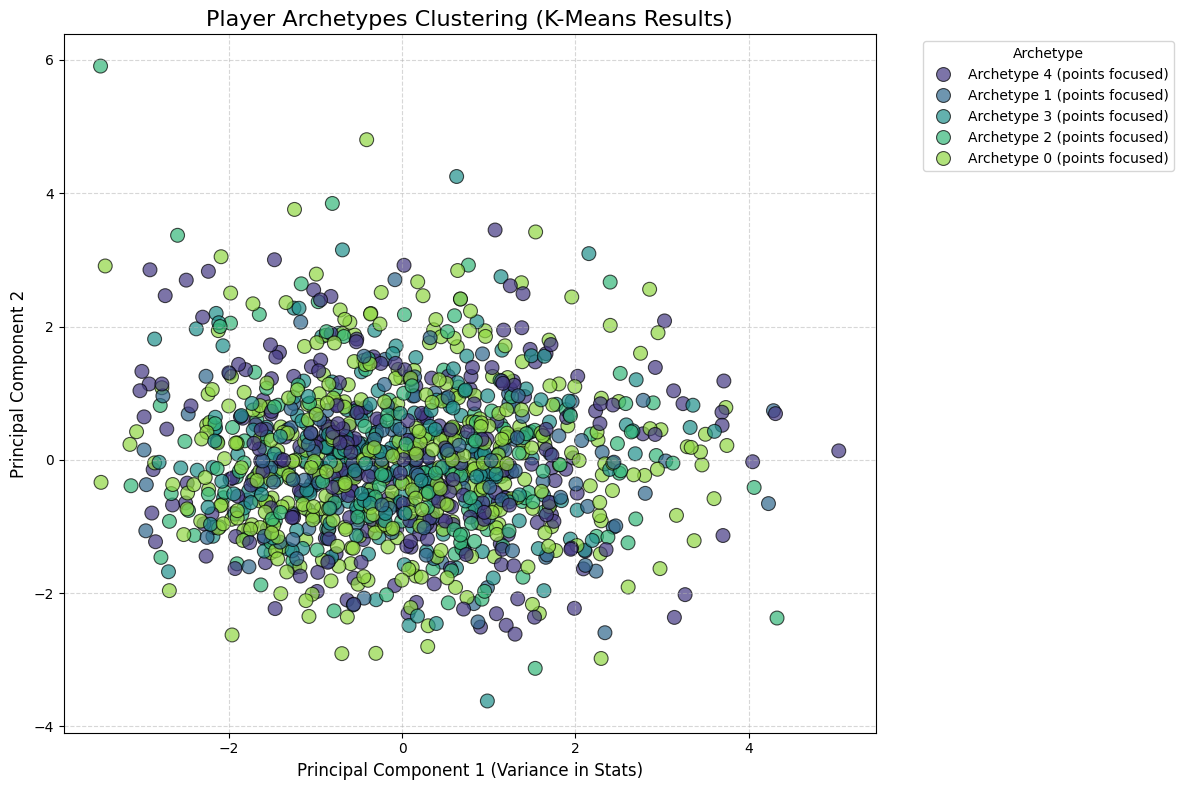


--- Archetype 0 (points focused) Example Players ---
Kevin Porter Jr. (Pts: 11, Reb: 3)
Mikal Bridges (Pts: 16, Reb: 6)
AJ Green (Pts: 19, Reb: 4)

--- Archetype 1 (points focused) Example Players ---
OG Anunoby (Pts: 16, Reb: 3)
Jayson Tatum (Pts: 22, Reb: 9)
Andrew Nembhard (Pts: 12, Reb: 4)

--- Archetype 2 (points focused) Example Players ---
Tristan Thompson (Pts: 3, Reb: 20)
Shai Gilgeous-Alexander (Pts: 24, Reb: 8)
Myles Turner (Pts: 23, Reb: 10)

--- Archetype 3 (points focused) Example Players ---
Giannis Antetokounmpo (Pts: 30, Reb: 20)
Jaylen Brown (Pts: 25, Reb: 6)
Craig Porter Jr. (Pts: 20, Reb: 5)

--- Archetype 4 (points focused) Example Players ---
Gary Trent Jr. (Pts: 33, Reb: 5)
Tyrese Maxey (Pts: 45, Reb: 4)
Nae'Qwan Tomlin (Pts: 24, Reb: 12)


In [7]:
# Normalize the features so large numbers (like Points) don't dominate small ones (like Steals)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

k = 5
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
df_clustering['Cluster'] = kmeans.fit_predict(X_scaled)

cluster_means = df_clustering.groupby('Cluster')[features].mean()

print("Cluster Centers (Average Per 36 Stats):")
print(cluster_means)

cluster_labels = {}
for i in range(k):
    # Find the stat this cluster excels at relative to the others
    top_stat = cluster_means.loc[i].idxmax().replace('_Per36', '')
    cluster_labels[i] = f"Archetype {i} ({top_stat} focused)"

df_clustering['Archetype_Label'] = df_clustering['Cluster'].map(cluster_labels)

# PCA Scatter plot
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plot_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
plot_df['Cluster'] = df_clustering['Cluster']
plot_df['Label'] = df_clustering['Archetype_Label']

plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='PC1',
    y='PC2',
    hue='Label',
    data=plot_df,
    palette='viridis',
    s=100,
    alpha=0.7,
    edgecolor='k'
)

plt.title('Player Archetypes Clustering (K-Means Results)', fontsize=16)
plt.xlabel('Principal Component 1 (Variance in Stats)', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)
plt.legend(title='Archetype', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Display sample players from each cluster
for i in range(k):
    print(f"\n--- {cluster_labels[i]} Example Players ---")
    # Show top 3 players in this cluster by minutes played
    examples = df_clustering[df_clustering['Cluster'] == i].sort_values('minutes_float', ascending=False).head(3)
    for _, row in examples.iterrows():
        print(f"{row['firstName']} {row['familyName']} (Pts: {row['points']}, Reb: {row['reboundsTotal']})")

## Feature Engineering for Prediction

### Train/Test Data



In [8]:
pacers_id=1610612754

# Helper column to distinguish Pacers vs Opponent
df_clustering['Is_Pacers'] = df_clustering['teamId'] == pacers_id

# Group by Game, Team(Is_Pacers), and Cluster
game_lineups = df_clustering.groupby(['GAME_ID', 'Is_Pacers', 'Cluster']).size().unstack(fill_value=0)

# Separate Pacers and Opponents stats
pacers_stats = game_lineups.xs(True, level='Is_Pacers').add_prefix('Pacers_Arch_')
opponent_stats = game_lineups.xs(False, level='Is_Pacers').add_prefix('Opp_Arch_')

# Combine into a single DataFrame per game
unique_games = df_clustering['GAME_ID'].unique()
model_data = pd.DataFrame(index=unique_games)
model_data = model_data.join(pacers_stats).join(opponent_stats).fillna(0)

# Add the Target Variable (Win/Loss)
game_results = df_clustering.groupby('GAME_ID')['WL'].first()
model_data['Target'] = game_results.map({'W': 1, 'L': 0})

model_data = model_data.dropna()

print("\n--- Game-Level Feature Vector (First 5 Rows) ---")
print(model_data.head())

# Features (X) and Target (y)
feature_cols = [c for c in model_data.columns if 'Arch_' in c]
X_dat = model_data[feature_cols]
y_dat = model_data['Target']
X_train, X_test, y_train, y_test = train_test_split(X_dat, y_dat, train_size=0.8, test_size=0.2, random_state=42)


--- Game-Level Feature Vector (First 5 Rows) ---
            Pacers_Arch_0  Pacers_Arch_1  Pacers_Arch_2  Pacers_Arch_3  \
0022401189              4              4              2              1   
0022401172              4              0              2              2   
0022401168              2              0              3              1   
0022401148              3              0              1              0   
0022401142              1              2              1              2   

            Pacers_Arch_4  Opp_Arch_0  Opp_Arch_1  Opp_Arch_2  Opp_Arch_3  \
0022401189              1           2           1           1           1   
0022401172              2           0           2           3           1   
0022401168              3           3           0           2           1   
0022401148              4           4           0           2           0   
0022401142              3           3           0           2           1   

            Opp_Arch_4  Target  
002240118

### K-NN

In [9]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

# Evaluation
print("\n--- KNN Classification Results ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


--- KNN Classification Results ---
Accuracy: 0.62

Confusion Matrix:
[[ 0  6]
 [ 2 13]]

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.68      0.87      0.76        15

    accuracy                           0.62        21
   macro avg       0.34      0.43      0.38        21
weighted avg       0.49      0.62      0.55        21



### Naive Bayes

In [10]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)

y_pred = gnb.predict(X_test)

# Evaluation
print("\n--- Niave Bayes Classification Results ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


--- Niave Bayes Classification Results ---
Accuracy: 0.5714285714285714

Confusion Matrix:
[[ 1  5]
 [ 4 11]]

Classification Report:
              precision    recall  f1-score   support

           0       0.20      0.17      0.18         6
           1       0.69      0.73      0.71        15

    accuracy                           0.57        21
   macro avg       0.44      0.45      0.45        21
weighted avg       0.55      0.57      0.56        21



In [11]:
model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Evaluattion
print(f"Accuracy:, {accuracy_score(y_test, y_pred):.2f}")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy:, 0.52
Confusion Matrix:
 [[ 1  5]
 [ 5 10]]
              precision    recall  f1-score   support

           0       0.17      0.17      0.17         6
           1       0.67      0.67      0.67        15

    accuracy                           0.52        21
   macro avg       0.42      0.42      0.42        21
weighted avg       0.52      0.52      0.52        21

